# Counting Museums

This chapter will introduce some of the aggregation functions available to us in Spark SQL. We are going to learn to do the following in this chapter:

**Count the number of museums in Zurich by performing a spatial join between the Cultural Points of Interests and City Boundaries.**




In [1]:
# %load './code/helpers/imports.py'
import notebook
import os.path, json, io, pandas
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (54, 60)


from retrying import retry # for exponential back down when calling TurboOverdrive API

import pyspark.sql.functions as func # resuse as func.coalace for example
from pyspark.sql.types import StringType, IntegerType, FloatType, DoubleType,DecimalType

import pandas as pandas
from geopandas import GeoDataFrame # Loading boundaries Data
from shapely.geometry import Point, Polygon, shape # creating geospatial data
from shapely import wkb, wkt # creating and parsing geospatial data
import overpy # OpenStreetMap API

from ast import literal_eval as make_tuple # used to decode data from java

# make sure nbextensions are installed
notebook.nbextensions.check_nbextension('usability/codefolding', user=True)

try:
    sc
except NameError:
    import pyspark
    sc = pyspark.SparkContext('local[*]')
    sqlContext = pyspark.sql.SQLContext(sc)


Populating the interactive namespace from numpy and matplotlib


In [2]:
# %load './code/helpers/load_boundaries_and_pois.py'
OVERPASS_API         = overpy.Overpass()
BASE_DIR             = os.path.join(os.path.abspath('.'), 'work-flow')
URBAN_BOUNDARIES_FILE = '06_Europe_Cities_Boundaries_with_Labels_Population.geo.json'

# Paths to base datasets that we are using:
URBAN_BOUNDARIES_PATH = os.path.join(BASE_DIR,URBAN_BOUNDARIES_FILE)
POIS_PATH            = os.path.join(BASE_DIR, "pois.json")

try:
    geo_df
except NameError:
    geo_df = GeoDataFrame.from_file(URBAN_BOUNDARIES_PATH)
    # Add a WKT column for use later
    geo_df['wkt'] = pandas.Series(
        map(lambda geom: str(geom.to_wkt()), geo_df['geometry']),
        index=geo_df.index, dtype='string')

try:
    boundaries_from_pd
except NameError:
    boundaries_from_pd = sqlContext.createDataFrame(geo_df)
    # boundaries_from_pd.createOrReplaceTempView("boundaries")
    boundaries_from_pd.registerTempTable("boundaries")

try:
    pois_df
except NameError:
    pois_df = sqlContext.read.json(POIS_PATH)
    pois_df = pois_df.toPandas()
    def toWktColumn(coords):
        return (Point(coords).wkt)

    pois_df['wkt'] = pandas.Series(
        map(lambda geom: toWktColumn(geom.coordinates), pois_df['geometry']),
        index=pois_df.index, dtype='string')

    pois_df = sqlContext.createDataFrame(pois_df)


# Count the number of museums in Zurich

So give what we know about our final goal of calculating the cultural score for each city we can start with smaller steps of running our analysis on a single city and for single type of location. So lets start with museums in Zurich.

## Exercise

* Count the number of museums in Zurich
HINT: You will need Shapely Spatial Operations

In [13]:
# --------------------- Solution Below -----------------------------#


## Solution

Our approach to finding the count of museums will be as follows:

1. Get all museums from POIs as Spark Dataframe
2. Get boundary of Zurich as Spark Dataframe
3. Get the Shapely Polygon Object for the Zurich boundary from the WKT string of the boundary geometry
4. Filter each POI by checking if it's coordinates (as Shapely Point Object) is within the boundary (as Shapely Polygon Object)

1358


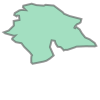

In [3]:
# Register a Temporary Table to allow us to call SQL-like statements
# in Apache Spark against the Points of Interests SparkSQL Dataframe:

# pois_df.createOrReplaceTempView("pois") # spark 2.0 version
pois_df.registerTempTable("pois")

# Select all museums:
museums = sqlContext.sql(
    "SELECT geometry, \
    properties.name, \
    properties.tourism \
    FROM pois WHERE properties.tourism = 'museum'")

# lets see how many museums we have in our POI dataset
print museums.count()

# Select Zurich from boundaries dataframe 

zurich = sqlContext.sql("SELECT wkt, POPEU2013 \
    FROM boundaries WHERE NAME = 'Zurich'")

# get the geographic boundary of Zurich as GeoJSON:
json_str = zurich.toJSON().take(1)[0]
json_obj = json.loads(json_str)
zurich_boundry = wkt.loads(json_obj['wkt'])
zurich_boundry

In [5]:
# filter museum rdd by performing a within operation
museums_in_zurich = museums.rdd.filter(
    lambda r: Point(r['geometry']['coordinates']).intersects(zurich_boundry)
)

print "museums.rdd class name: ", museums.rdd.__class__.__name__
print "museums_in_zurich class name: ", museums_in_zurich.__class__.__name__
print "museums_in_zurich.collect() class name: ", museums_in_zurich.collect().__class__.__name__
print "count of museums in zurich: ", museums_in_zurich.count()


museums.rdd class name:  RDD
museums_in_zurich class name:  PipelinedRDD
museums_in_zurich.collect() class name:  list
count of museums in zurich:  25


### Filtering by Spatial Predicate

Notice how we call `museums.rdd.filter` on the Spark Dataframe. This requires a bit of explaining. 

Firstly the call to [`Dataframe.rdd`](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.rdd) returns an RDD representing the Dataframe. We then call filter on the RDD with a lambda function that will filter each item by weather or not it lies inside the Zurich boundary.

As we know RDD `transformations` are lazily evaluated when an `action` is performed. Notice how when we go to print the filtered value, it prints out that it is an RDD and that the type is a PipelinedRDD not a list of values as we might expect. That's because we haven't performed an `action` yet, we've only performed a `transformation` by calling `filter`. The `action` is only performed when we call `collect()` or `count()` which are both actions.

In [10]:
# go from RDD to dataframe and show the results
museums_in_zurich_df = sqlContext.createDataFrame(museums_in_zurich)
museums_in_zurich_df.show()

+--------------------+--------------------+-------+
|            geometry|                name|tourism|
+--------------------+--------------------+-------+
|[WrappedArray(8.5...|Ortsmuseum Wollis...| museum|
|[WrappedArray(8.5...|      Kriminalmuseum| museum|
|[WrappedArray(8.5...|Museum für Gestal...| museum|
|[WrappedArray(8.5...|Museum Porzellan ...| museum|
|[WrappedArray(8.5...|   Zivilschutzmuseum| museum|
|[WrappedArray(8.5...|    Ortsmuseum Höngg| museum|
|[WrappedArray(8.5...|     Museum Rietberg| museum|
|[WrappedArray(8.5...|Museum der Zeitme...| museum|
|[WrappedArray(8.5...|  Gasthaus zum Bären| museum|
|[WrappedArray(8.4...|Ortsmuseum Altste...| museum|
|[WrappedArray(8.5...|    Haus Konstruktiv| museum|
|[WrappedArray(8.5...| Tram-Museeum Zürich| museum|
|[WrappedArray(8.5...| Museum der Kulturen| museum|
|[WrappedArray(8.5...|       Coninx-Museum| museum|
|[WrappedArray(8.4...|Ortsmuseum Albisr...| museum|
|[WrappedArray(8.5...|Zoologisches und ...| museum|
|[WrappedArr